### I. Import Various Libraries, Read in data and Remove Data Errors

In [6]:
import talib
import zipline
import time
import pandas as pd
from datetime import datetime,timedelta
import statsmodels.api as sm
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick2_ohlc
import plotly.plotly as py
from sklearn import linear_model,svm,ensemble,cross_validation,grid_search,metrics,kernel_ridge
from plotly.tools import FigureFactory as FF

%matplotlib inline

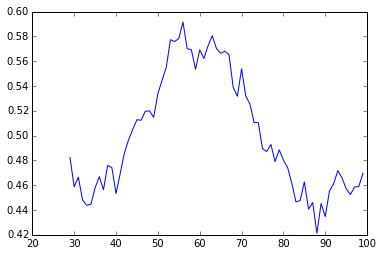

In [7]:
#test talib
close = np.random.random(100)
output = talib.SMA(close)
plt.plot(output)

In [8]:
df=pd.read_csv('/home/nightrose/Documents/Github/try/xyz/data.1_min.csv',header=None,names=('time','price'))
df.head()

,time,price
0,1990-01-08 15:32:00,411.25
1,1990-01-08 15:33:00,411.25
2,1990-01-08 15:34:00,411.75
3,1990-01-08 15:35:00,411.50
4,1990-01-08 15:36:00,411.50


In [9]:
df.time=[datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in df.time]

In [ ]:
type(df.time[0])

In [ ]:
df=df.set_index('time')

In [ ]:
#plotting it along time line, found an outlier
df.plot()

In [ ]:
#replace the price point with price in the previous minute. 
temp=df[df['price']>5000].index
df.loc[temp,'price']=df.loc[temp+timedelta(minutes=1),'price']

In [ ]:
#check to see whether outliers are all removed
df.plot()

In [ ]:
#check for duplications
df.index.is_unique

In [ ]:
df_daily=df.resample('B',how='ohlc')
df_daily.head(10)
df_daily.dropna(how='any',axis=0,inplace=True)

In [ ]:
o=df_daily['price']['open']
c=df_daily['price']['close']
h=df_daily['price']['high']
l=df_daily['price']['low']
a=range(len(df_daily.index))
new=[]
for i in a:
    if i%365==0:
      new.append(i)  
x=df_daily.index.strftime('%Y')

In [ ]:
fig = plt.figure(figsize=(18,4))
ax1 = plt.subplot(1,1,1)
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(new,x[new], rotation=45)
candlestick2_ohlc(ax1,o,h,l,c,width=1,colorup='k',colordown='r')
ax1.autoscale_view()
fig.autofmt_xdate()

In [ ]:
df_daily['log_returns_close']= np.log(df_daily['price']['close']) - np.log(df_daily['price']['close'].shift(1))
df_daily['log_returns_open']= np.log(df_daily['price']['open']) - np.log(df_daily['price']['open'].shift(1))
df_daily['log_returns_high']= np.log(df_daily['price']['high']) - np.log(df_daily['price']['high'].shift(1))
df_daily['log_returns_low']= np.log(df_daily['price']['low']) - np.log(df_daily['price']['low'].shift(1))

In [ ]:
df_daily.drop(df_daily.head(1).index,inplace=True)

In [ ]:
df_daily.head(10)

In [ ]:
df_daily['log_returns_close'].plot()

In [ ]:
fig=plt.figure(figsize=(18,4))
fig.suptitle('Security Daily Returns',y=1.05,fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df_daily['log_returns_close'])
ax2=fig.add_subplot(132)
ax2=sm.graphics.tsa.plot_acf(df_daily['log_returns_close'],lags=30,ax=ax2)
ax3=fig.add_subplot(133)
ax3=sm.graphics.tsa.plot_pacf(df_daily['log_returns_close'],lags=30,ax=ax3)


In [ ]:
fig=plt.figure(figsize=(18,18))
ax1=fig.add_subplot(311)
ax1.set_title('30 day moving average',fontsize=16)
ax1=pd.rolling_mean(df_daily['log_returns_close'],30).plot()
ax1=plt.axhline(y=0,color='black')

ax2=fig.add_subplot(312)
ax2.set_title('60 day moving average',fontsize=16)
ax2=pd.rolling_mean(df_daily['log_returns_close'],60).plot()
ax2=plt.axhline(y=0,color='black')

ax3=fig.add_subplot(313)
ax3.set_title('30 day rolling standard deviation',fontsize=16)
ax3=pd.rolling_std(df_daily['log_returns_close'],60).plot()

It seems that the volativity increased over time and that should be incorporated into the model building. 

In [ ]:
#look at within day price variations
df.tail()

check the last several days minute by minute patterns

## Explore minute by minute returns

In [ ]:
start = '01/10/1990'
end = '02/10/1990'
df_last=df[start:end]
df_last.plot()

In [ ]:
df_last.loc[:,'log_returns_min']= np.log(df_last.loc[:,'price']) - np.log(df_last.loc[:,'price'].shift(1))
df_last.drop(df_last.head(1).index,inplace=True)
df_last['log_returns_min'].plot()

In [ ]:
#df_last.ix['1990-01-10 19:00:00':'1990-01-11 16:00:00', 'log_returns_min']

In [ ]:
df_last['log_returns_min'].describe()

In [ ]:
fig=plt.figure(figsize=(18,4))
fig.suptitle('Minute by Minute Returns from %s to %s'%(start,end),y=1.05,fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df_last['log_returns_min'])
ax2=fig.add_subplot(132)
#ax2=sm.graphics.tsa.plot_acf(df_last['log_returns_min'],lags=30,ax=ax2)
ax2=sm.graphics.tsa.plot_acf(df_last['log_returns_min'],lags=10,ax=ax2)
ax3=fig.add_subplot(133)
ax3=sm.graphics.tsa.plot_pacf(df_last['log_returns_min'],lags=30,ax=ax3)

In [ ]:
ACF0=sm.tsa.stattools.acf(df_last['log_returns_min'], nlags=14)
#ACF0.plot()
plt.bar(np.arange(14),ACF0[1:15])

In [ ]:
window=500
aa=pd.rolling_corr(df_last['log_returns_min'],df_last['log_returns_min'].shift(1),window)

fig=plt.figure(figsize=(18,6))
fig.suptitle('Minute by Minute Returns Rolling Correlation ( %s minutes)' %(window),y=1.05,fontsize=20)
ax1 = fig.add_subplot(121)
ax1=plt.hist(aa.ix[window:])
ax1=plt.axvline(x=0,color='black')
ax2=fig.add_subplot(122)
ax2=aa.plot()
ax2=plt.axhline(y=0,color='black')

In [ ]:
minute_lag=np.zeros((len(df_last),7))
for i in range(0,7):
    minute_lag[:,i]=df_last['log_returns_min'].shift(i+1)
dd=pd.DataFrame(minute_lag)
dd.columns=['min_lg1','min_lg2','min_lg3','min_lg4','min_lg5','min_lg6','min_lg7']
dd=dd.set_index(df_last.index)
dd_minute=pd.merge(df_last,dd, left_index=True, right_index=True)
f=dd_minute.corr()[[1]]
f[2:]

In [ ]:
dd_minute['Rolling_Std_5'] = pd.rolling_std(dd_minute[['price']],window=5)
dd_minute['Rolling_Std_25'] = pd.rolling_std(dd_minute[['price']],window=25)
dd_minute['Rolling_Std_50'] = pd.rolling_std(dd_minute[['price']],window=50)
dd_minute['Rolling_Std_150'] = pd.rolling_std(dd_minute[['price']],window=150)
dd_minute.corr()

In [ ]:
#total sample
#X_1=dd_minute[151:].drop(['price', 'log_returns_min'], axis=1).as_matrix()
X_1=dd_minute[151:][['min_lg1','Rolling_Std_5']].as_matrix()
y_1=dd_minute[151:]['log_returns_min'].as_matrix()
y_1.shape

In [ ]:
ss=len(y_1)
sz=ss/10
if ss%10==0:
    pass
else: 
    sz=round(sz)
#Testing sets
X_1_test=X_1[-sz:,:] #keep the last 3074 minutes as testing
y_1_test=y_1[-sz:]

#Training sets
X_1_training=X_1[:-sz,:] #keep the last 3074 minutes as testing
y_1_training=y_1[:-sz]

In [ ]:
regr = linear_model.LinearRegression()
    # Train the model using the training sets
regr.fit(X_1_training, y_1_training)
pred=regr.predict(X_1_test)
#ab=pd.merge(pd.DataFrame(pred),pd.DataFrame(y_1_test))
#np.concatenate((pred.T,y_1_test.T),axis=1)
#ab
plt.plot(pred,color='red')
plt.plot(y_1_test,color='blue')
np.corrcoef(pred,y_1_test)
a=pred>0
b=y_1_test>0
print np.sum(a==b)
print (len(pred))
from __future__ import division
159/264
#print('R^2: %.2f' % regr.score(X_1_test,  y_1_test))
std_true=np.std(y_1_test)
std_est=np.std(pred)

rss=np.mean((pred/std_est*std_true-y_1_test)**2)
mn=np.mean(y_1_test)
tss=np.mean((y_1_test-mn)**2)

print("rss is %s, tss is %s" % (rss,tss))
print("R^2 is %s" % ((tss-rss)/tss))
#rss=np.mean((pred - y_1_test) ** 2)
#print("Residual sum of squares: %.2f" % rss)

In [ ]:
columns=['Model','R^2','Residual sum of squares','Best Parameters','Data_Range']
model_comparison=pd.DataFrame(columns=columns)

In [ ]:
def linear_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_tr, y_tr)
    rss=np.mean((regr.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    print('R^2: %.2f' % regr.score(X_te,  y_te))
    return (regr.score(X_te,  y_te),rss,regr.coef_)

In [ ]:
R_2,Rss,Param=linear_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'linear', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [ ]:
class TimeSeriesCV():
    def __init__(self,n,fold):
        self.n=n
        self.fold=fold
    def __iter__(self):
        if self.n<(self.fold+1):
            print("too many folds")
        m=self.n%(self.fold+1)
        chunk=np.arange(self.n)#entire series
        size=(self.n-m)/(self.fold+1)#size of each fold, size of the first fold is size+m
        for i in np.arange(self.fold):
            train_index = chunk[0:(size*(i+1)+m)]
            test_index = chunk[(size*(i+1)+m):(size*(i+2)+m)]
            yield train_index, test_index
    def __len__(self):
        return self.fold 

In [ ]:
def kernel_ridge_version(X_tr,y_tr,X_te,y_te,f):
    # Create linear regression object

    tuned_parameters = [{'kernel':['linear'],'alpha': [0.001,0.05,0.01,0.1,1]},
                         {'kernel':['rbf'],'alpha':[0.001,0.05,0.01,0.1,1],'gamma':[0.1,1,10,100,500]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(kernel_ridge.KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=f),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

In [ ]:
#first half
R_2,Rss,Param=kernel_ridge_version(X_1_training,y_1_training,X_1_test,y_1_test,5)
model_comparison = model_comparison.append({'Model':'Kernel Ridge', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [ ]:
def svm_version(X_tr,y_tr,X_te,y_te,f):
    # Create linear SVR object
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10,20,30, 50,60,70,80,90,100,1000]}]
    print("# Tuning hyper-parameters")

    clf = grid_search.GridSearchCV(svm.SVR(C=1), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=f),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

In [ ]:
R_2,Rss,Param=svm_version(X_1_training,y_1_training,X_1_test,y_1_test,5)
model_comparison = model_comparison.append({'Model':'SVM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

## look at daily changes since 2009

In [ ]:

daily_2009=df_daily['01/01/2009'::]['log_returns_close']
fig=plt.figure(figsize=(18,12))
ax1=fig.add_subplot(211)
ax1.set_title('daily returns',fontsize=16)
ax1=daily_2009.plot()
ax2=plt.axhline(y=0,color='black')
ax2=fig.add_subplot(212)
ax2=pd.rolling_mean(daily_2009,30).plot()
ax2=plt.axhline(y=0,color='black')

In [ ]:
fig=plt.figure(figsize=(18,6))
ax1=fig.add_subplot(121)
ax1=sm.graphics.tsa.plot_acf(daily_2009,lags=7,ax=ax1)
ax2=fig.add_subplot(122)
ax2=sm.graphics.tsa.plot_pacf(daily_2009,lags=7,ax=ax2)

In [ ]:
ACF=sm.tsa.stattools.acf(daily_2009, nlags=7)
ACF

There might be correlation in one day lag and 5 day lags. 

In [ ]:
daily_2009_lag=np.zeros((len(daily_2009),7))
for i in range(0,7):
    daily_2009_lag[:,i]=daily_2009.shift(i+1)
d09lag2=pd.DataFrame(daily_2009_lag)
d09lag2.head(10)

In [ ]:
d09lag2.columns=['close_lg1','close_lg2','close_lg3','close_lg4','close_lg5','close_lg6','close_lg7']
d09lag2=d09lag2.set_index(daily_2009.index)
daily_2009[daily_2009.index<>d09lag2.index]
#daily_2009[pd.isnull(daily_2009)==True]
pd.DataFrame(daily_2009['01/02/2009':'01/09/2009'])


In [ ]:
d09lag2['01/02/2009':'01/09/2009']
#d09lag2[pd.isnull(d09lag2).any(axis=1)]

In [ ]:
df_close_lags=pd.merge(pd.DataFrame(daily_2009),d09lag2, left_index=True, right_index=True)
a=df_close_lags.corr()[[0]]
a

In [ ]:
daily_2009_o=df_daily['01/01/2009'::]['log_returns_open']
daily_2009_lag_o=np.zeros((len(daily_2009_o),7))
for i in range(0,7):
    daily_2009_lag_o[:,i]=daily_2009_o.shift(i+1)
d09lag2_o=pd.DataFrame(daily_2009_lag_o)
d09lag2_o.columns=['open_lg1','open_lg2','open_lg3','open_lg4','open_lg5','open_lg6','open_lg7']
d09lag2_o=d09lag2_o.set_index(daily_2009_o.index)
df_co_lags=pd.merge(pd.DataFrame(daily_2009_o),d09lag2_o, left_index=True, right_index=True)
b=df_co_lags.corr()[[0]]
b

In [ ]:
daily_2009_h=df_daily['01/01/2009'::]['log_returns_high']
daily_2009_lag_h=np.zeros((len(daily_2009_h),7))
for i in range(0,7):
    daily_2009_lag_h[:,i]=daily_2009_h.shift(i+1)
d09lag2_h=pd.DataFrame(daily_2009_lag_h)
d09lag2_h.columns=['high_lg1','high_lg2','high_lg3','high_lg4','high_lg5','high_lg6','high_lg7']
d09lag2_h=d09lag2_h.set_index(daily_2009_h.index)
df_ch_lags=pd.merge(pd.DataFrame(daily_2009_h),d09lag2_h, left_index=True, right_index=True)
c=df_ch_lags.corr()[[0]]
c

In [ ]:
daily_2009_l=df_daily['01/01/2009'::]['log_returns_low']
daily_2009_lag_l=np.zeros((len(daily_2009_l),7))
for i in range(0,7):
    daily_2009_lag_l[:,i]=daily_2009_l.shift(i+1)
d09lag2_l=pd.DataFrame(daily_2009_lag_l)
d09lag2_l.columns=['low_lg1','low_lg2','low_lg3','low_lg4','low_lg5','low_lg6','low_lg7']
d09lag2_l=d09lag2_l.set_index(daily_2009_l.index)
df_cl_lags=pd.merge(pd.DataFrame(daily_2009_l),d09lag2_l, left_index=True, right_index=True)
d=df_cl_lags.corr()[[0]]
d

In [ ]:
fig=plt.figure(figsize=(18,12))
daily_2009['07/01/2012'::].plot(color="red")
daily_2009_o['07/01/2012'::].plot(color="blue")
daily_2009_h['07/01/2012'::].plot(color="green")
daily_2009_l['07/01/2012'::].plot(color="yellow")
plt.axhline(y=0,color='black')

In [ ]:
df_close_lags=pd.merge(pd.DataFrame(daily_2009),d09lag2, left_index=True, right_index=True)
df_co_lags2=pd.merge(df_close_lags,d09lag2_o,left_index=True, right_index=True)
df_coh_lags2=pd.merge(df_co_lags2,d09lag2_h,left_index=True, right_index=True)
df_cohl_lags=pd.merge(df_coh_lags2,d09lag2_l, left_index=True, right_index=True)
e=df_cohl_lags.corr()
e

### Try model building

In [ ]:
df_lag=np.zeros((len(df_daily),7))
for i in range(0,7):
    df_lag[:,i]=df3['signal_shift_returns'].shift(i)
df_lag2=pd.DataFrame(df_lag)
df_lag2.columns=['sr_lg1','sr_lg2','sr_lg3','sr_lg4','sr_lg5','sr_lg6','sr_lg7']
df_lag2=df_lag2.set_index(df3.index)
df_with_lags=pd.merge(df3,df_lag2,left_index=True,right_index=True,how='left')

In [ ]:
#First half
X_1=df_lag2.loc['2012-01-13':'2013-03-31'].as_matrix()
y_1=df3.loc['2012-01-13':'2013-03-31','spy_returns'].as_matrix()
#Second half
X_2=df_lag2.loc['2013-04-01':'2014-08-29'].as_matrix()
y_2=df3.loc['2013-04-01':'2014-08-29','spy_returns'].as_matrix()
#Testing sets
X_1_test=X_1[-45:,:] #keep the last 30 days as testing
y_1_test=y_1[-45:]
X_2_test=X_2[-60:,:] #keep the last 30 days as testing
y_2_test=y_2[-60:]
#Training sets
X_1_training=X_1[:-45,:] #keep the last 30 days as testing
y_1_training=y_1[:-45]
X_2_training=X_2[:-60:,:] #keep the last 30 days as testing
y_2_training=y_2[:-60]

In [ ]:
columns=['Model','R^2','Residual sum of squares','Best Parameters','Data_Range']
model_comparison=pd.DataFrame(columns=columns)

In [ ]:
def linear_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_tr, y_tr)
    rss=np.mean((regr.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    print('R^2: %.2f' % regr.score(X_te,  y_te))
    return (regr.score(X_te,  y_te),rss,regr.coef_)

In [ ]:
#first half
R_2,Rss,Param=linear_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'linear', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [ ]:
lass TimeSeriesCV():
    def __init__(self,n,fold):
        self.n=n
        self.fold=fold
    def __iter__(self):
        if self.n<(self.fold+1):
            print("too many folds")
        m=self.n%(self.fold+1)
        chunk=np.arange(self.n)#entire series
        size=(self.n-m)/(self.fold+1)#size of each fold, size of the first fold is size+m
        for i in np.arange(self.fold):
            train_index = chunk[0:(size*(i+1)+m)]
            test_index = chunk[(size*(i+1)+m):(size*(i+2)+m)]
            yield train_index, test_index
    def __len__(self):
        return self.fold 

In [ ]:
def kernel_ridge_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object

    tuned_parameters = [{'kernel':['linear'],'alpha': [0.001,0.05,0.01,0.1,1]},
                         {'kernel':['rbf'],'alpha':[0.001,0.05,0.01,0.1,1],'gamma':[0.1,1,10,100,500]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(kernel_ridge.KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=5))
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

In [ ]:
#first half
R_2,Rss,Param=kernel_ridge_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'Kernel Ridge', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [ ]:
def svm_version(X_tr,y_tr,X_te,y_te):
    # Create linear SVR object
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10,20,30, 50,60,70,80,90,100,1000]}]
    print("# Tuning hyper-parameters")

    clf = grid_search.GridSearchCV(svm.SVR(C=1), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=5),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))

    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)